# Orbital Mechanics and Control
## Import Packages

In [1]:
import orbit
from satellite import Satellite
from dynamics import equation_of_motion

import numpy as np
from scipy.integrate import ode, DOP853
import matplotlib.pyplot as plt


## Input variables
Initialize Orbit using one of the following methods:
- Classical Elements
- State Vector

If necessary, implement the conversion to State Vector for the following:
- Delaunay Elements
- Equinoctial Elements

These functionalities should be added from the Orbit abstract class in orbit.py

In [2]:
# Curtir - Example 12.1
r0 = [5873.40, -658.522, 3007.49]
v0 = [-2.89641, 4.09401, 6.14446]
orbit0 = orbit.OrbitStateVector(r0,v0)

R, mu = orbit0.get_central_body()       # Get central body according to orbit
orbit0.activate_perturbation(["Drag"])  # Select perturbations

from math import pi
sat0 = Satellite(orbit0,mass=100,cd=2.2,area=pi*0.5**2)

satellites = [sat0]

Using atmospheric drag (Standard 1976).


## Time setup

In [3]:
# Define simulation time in seconds
t0        = 0
time_end  = 3600*24*120
time_step = 300
times     = np.arange(0,time_end,step=time_step)

## Linear Control

In [4]:
# Tune control law used
Kp = 0
Ki = 0
Kd = 0

## Simulation

In [5]:
# Simulate orbit
solver  = ode(equation_of_motion)
solver.set_integrator('DOP853')
solver.set_f_params(orbit0,sat0)
solver.set_initial_value(orbit0.initial_state,t0)


for time in times:
    solver.integrate(time)
    sat0.save_state(solver.y)

X,Y,Z,*rest = sat0.get_state()

/home/msb/Codes/PY/orbital-mechanics/env/lib/python3.10/site-packages/scipy/integrate/_ode.py:431: UserWarning: dop853: step size becomes too small
  self._y, self.t = mth(self.f, self.jac or (lambda: None),
/home/msb/Codes/PY/orbital-mechanics/env/lib/python3.10/site-packages/scipy/integrate/_ode.py:431: UserWarning: dop853: larger nsteps is needed
  self._y, self.t = mth(self.f, self.jac or (lambda: None),


## Plots

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


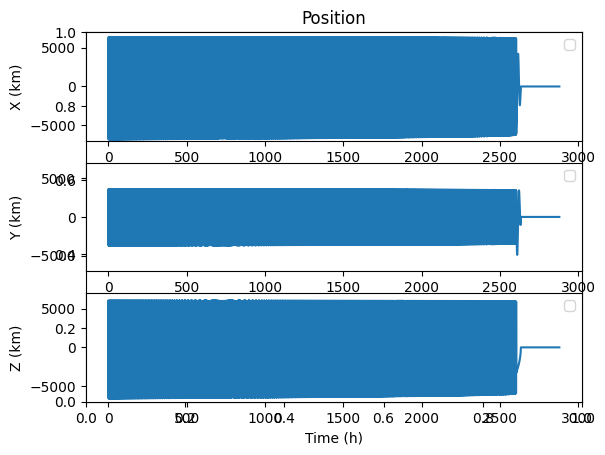

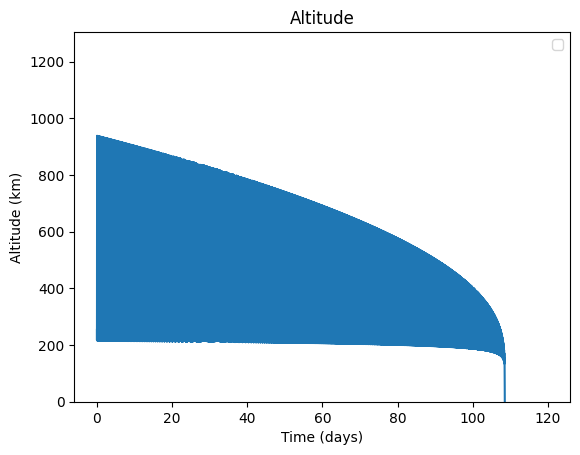

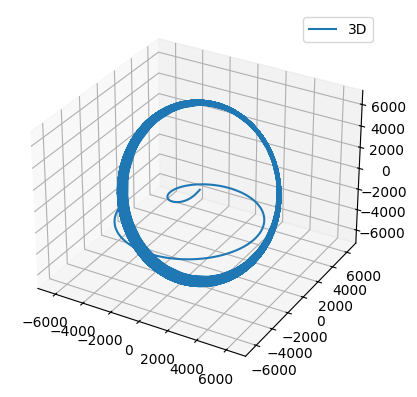

In [6]:
# Plot graphics and return coordinates in ECI frame
graph = plt.figure(1)
plt.title("Position")

plt.subplot(311)
plt.plot(times/3600,X)
plt.ylim([-7_000,7_000])
plt.ylabel("X (km)")
plt.legend()

plt.subplot(312)
plt.plot(times/3600,Y)
plt.ylim([-7_000,7_000])
plt.ylabel("Y (km)")
plt.legend()

plt.subplot(313)
plt.plot(times/3600,Z)
plt.ylim([-7_000,7_000])
plt.xlabel("Time (h)")
plt.ylabel("Z (km)")
plt.legend()

altitude = plt.figure(2)
plt.title("Altitude")
alt = [np.sqrt(X[i]**2 + Y[i]**2 + Z[i]**2) - R for i in range(len(times))]
plt.plot(times/(3600*24), alt)
plt.xlabel("Time (days)")
plt.ylabel("Altitude (km)")
plt.ylim(bottom=0)
plt.legend()

tri = plt.figure(3)
ax = tri.add_subplot(111,projection='3d')
ax.plot(X,Y,Z, label='3D')
ax.set_xlim((-7000,7000))
ax.set_ylim((-7000,7000))
ax.set_zlim((-7000,7000))
ax.legend()

plt.show()


In [7]:
max(alt)

938.7412743228251